In [1]:
 # used to handle data
import pandas as pd

# used to handle gcp data

import geopandas as gpd

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np
from scipy.interpolate import griddata

# Plotting library
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


import folium

# tells matplotlib to embed plots within the notebook
# %matplotlib inline

# Geodetic Project
### RTK drone

Read data

In [42]:
df = pd.read_csv(r'data\GCP.csv')
df2 = pd.read_csv(r'data\calibrated_images_position.csv')

# Create GCPs GoeDataFrame
points = gpd.points_from_xy(x=df.x, y=df.y)
df['geometry'] = points
gcp = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:2039")

# Create images positions GoeDataFrame
img_points = gpd.points_from_xy(x=df2.x, y=df2.y)
df2['geometry'] = img_points
img = gpd.GeoDataFrame(df2, geometry='geometry', crs="EPSG:2039")

# # saving to shapefile
# gcp.to_file('GCP.shp')


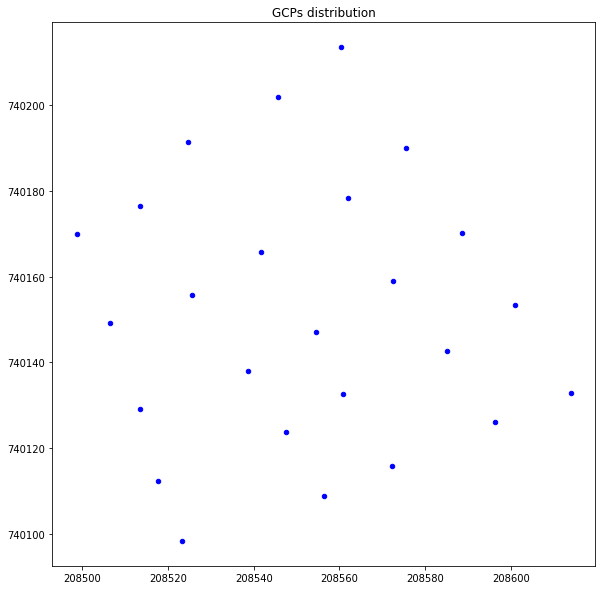

In [3]:
# 2D plot
gcp.plot(figsize=(10, 10), color='b', markersize=20)
plt.title('GCPs distribution')
plt.savefig('GCPs distribution.png')

In [4]:
# map plot

# convert from ITM to WGS84
interFeature = gcp.to_crs("+proj=tmerc +lat_0=31.7343936111111 +lon_0=35.2045169444445 +k=1.0000067 +x_0=219529.584 +y_0=626907.39 +ellps=GRS80 +towgs84=-23.772,-17.490,-17.859,-0.31320,-1.85274,1.67299,5.4262 +units=m +no_defs")
crs_4326 =  {'init': 'epsg:4326'}
gcp_4326 = interFeature.to_crs(crs_4326)

lats = gcp_4326.geometry.y
lons = gcp_4326.geometry.x
names = gcp_4326['point']
centrum = [lats.mean(),lons.mean()]

map=folium.Map(location=centrum,
               tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
               attr = 'Esri',
               name = 'Esri Satellite',
               zoom_start=16)
# map=folium.Map(location=centrum,zoom_start=16)

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = False,
#         control = True
#        ).add_to(map)

for lat,lon,name in zip(lats,lons,names):
    map.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name))))
map

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


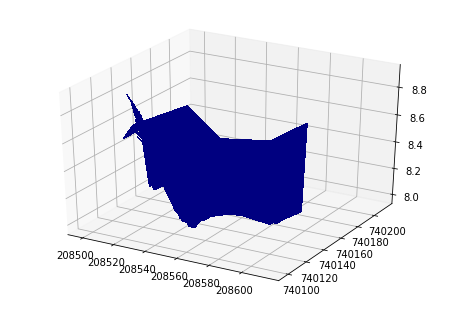

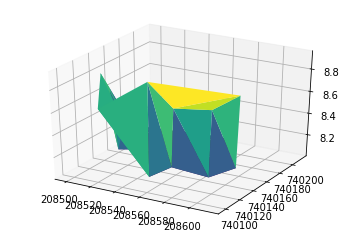

In [31]:
# 3D plot
# option 1
X, Y= np.meshgrid(df.x, df.y)
Z = griddata((df['x'], df['y']), df['z'], (X, Y), method='cubic')

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

# option 2
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df.x, df.y, df.z, cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

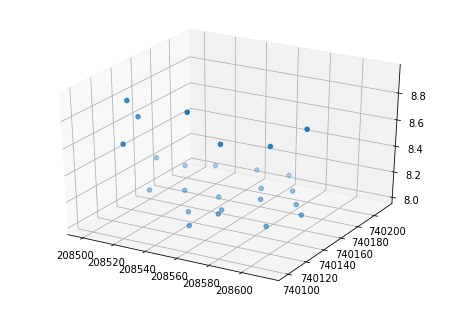

In [37]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df.x, df.y, df.z)
plt.show()

# # to Add a color bar which maps values to colors.
# surf=ax.plot_trisurf(df['y'], df['x'], df['z'], cmap=plt.cm.viridis, linewidth=0.2)
# fig.colorbar( surf, shrink=0.5, aspect=5)
# plt.show()

In [57]:
def map_plot(geoDataFrame, crs=None, tiles=None):
    """

    :param geoDataFrame: GeoPandas.GeoDataFrame
    :param crs: coordinate system
    :param tile: “OpenStreetMap”
                “Mapbox Bright” (Limited levels of zoom for free tiles)
                “Mapbox Control Room” (Limited levels of zoom for free tiles)
                “Stamen” (Terrain, Toner, and Watercolor)
                “Cloudmade” (Must pass API key)
                “Mapbox” (Must pass API key)
                “CartoDB” (positron and dark_matter)
    :return: map with points
    """
    # convert from ITM to WGS84
    if crs == "EPSG:2039":
        interFeature = geoDataFrame.to_crs("+proj=tmerc +lat_0=31.7343936111111 +lon_0=35.2045169444445 +k=1.0000067 +x_0=219529.584 +y_0=626907.39 +ellps=GRS80 +towgs84=-23.772,-17.490,-17.859,-0.31320,-1.85274,1.67299,5.4262 +units=m +no_defs")
        crs_4326 =  {'init': 'epsg:4326'}
        geoDataFrame_4326 = interFeature.to_crs(crs_4326)

    # map
    lats = geoDataFrame_4326.geometry.y
    lons = geoDataFrame_4326.geometry.x
    names = geoDataFrame_4326.iloc[:,0]
    centrum = [lats.mean(),lons.mean()]

    if tiles == 'Esri':
        map=folium.Map(location=centrum,
                       tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                       attr = 'Esri',
                       name = 'Esri Satellite',
                       zoom_start=16)
    else:
        map=folium.Map(location=centrum, tiles=tiles,zoom_start=16)

    for lat,lon,name in zip(lats,lons,names):
        map.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name))))
    return map

In [43]:
map_plot(gcp,'EPSG:2039','OpenStreetMap')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [44]:
map_plot(gcp,'EPSG:2039','Esri')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [58]:
map_plot(img,'EPSG:2039','Esri')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
